In [40]:
import requests, gzip, io, os, json

# for data mgmt
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import ast

# for plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import plotly.graph_objects as go
import seaborn as sns
from matplotlib.colors import to_rgba
import plotly.express as px

# for hypothesis testing
from scipy.stats import chi2_contingency
from scipy.stats import pareto

import warnings
warnings.filterwarnings("ignore")

# provide folder_name which contains uncompressed data i.e., csv and jsonl files
# only need to change this if you have already downloaded data
# otherwise data will be fetched from google drive
global folder_name
folder_name = 'data/local'

def fetch_small_data_from_github(fname):
    url = f"https://raw.githubusercontent.com/acd-engine/jupyterbook/master/data/analysis/{fname}"
    response = requests.get(url)
    rawdata = response.content.decode('utf-8')
    return pd.read_csv(io.StringIO(rawdata))

def check_if_csv_exists_in_folder(filename):
    try: return pd.read_csv(os.path.join(folder_name, filename), low_memory=False)
    except: return None

def fetch_data(filetype='csv', acdedata='organization'):
    filename = f'acde_{acdedata}_202307131040.{filetype}'

    # first check if the data exists in current directory
    data_from_path = check_if_csv_exists_in_folder(filename)
    if data_from_path is not None: return data_from_path

    urls = fetch_small_data_from_github('acde_data_gdrive_urls.csv')
    sharelink = urls[urls.data == acdedata][filetype].values[0]
    url = f'https://drive.google.com/u/0/uc?id={sharelink}&export=download&confirm=yes'

    response = requests.get(url)
    decompressed_data = gzip.decompress(response.content)
    decompressed_buffer = io.StringIO(decompressed_data.decode('utf-8'))

    try:
        if filetype == 'csv': df = pd.read_csv(decompressed_buffer, low_memory=False)
        else: df = [json.loads(jl) for jl in pd.read_json(decompressed_buffer, lines=True, orient='records')[0]]
        return pd.DataFrame(df)
    except: return None 

persons = fetch_data(acdedata = 'person')
events = fetch_data(acdedata = 'event')

,_id,data_source,_class,_class_ori,ori_id,ori_dbid,ori_url,date_created,date_modified,record_status,...,tags,urls,videoid_(CO-vids),related_events,related_organizations,related_people,related_places,related_recognitions,related_resources,related_works
0,"{""$oid"": ""6457d1d05fc8586b19976352""}","""CircusOZ""","""person""","""person""","""P0001""",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"""180, 183""","[{""relation_class"": ""Person_RelatedEvent"", ""da...",NaN,NaN,NaN,NaN,NaN,NaN
1,"{""$oid"": ""6457d1d05fc8586b19976353""}","""CircusOZ""","""person""","""person""","""P0002""",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"""104, 105""","[{""relation_class"": ""Person_RelatedEvent"", ""da...",NaN,NaN,NaN,NaN,NaN,NaN
2,"{""$oid"": ""6457d1d05fc8586b19976354""}","""CircusOZ""","""person""","""person""","""P0003""",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"[{""relation_class"": ""Person_RelatedEvent"", ""da...",NaN,NaN,NaN,NaN,NaN,NaN
3,"{""$oid"": ""6457d1d05fc8586b19976355""}","""CircusOZ""","""person""","""person""","""P0004""",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"""278""","[{""relation_class"": ""Person_RelatedEvent"", ""da...",NaN,NaN,NaN,NaN,NaN,NaN
4,"{""$oid"": ""6457d1d05fc8586b19976356""}","""CircusOZ""","""person""","""person""","""P0005""",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"""59, 179""","[{""relation_class"": ""Person_RelatedEvent"", ""da...",NaN,NaN,NaN,NaN,NaN,NaN


Indigeneous artists/designers with the most international exhibitions:


"Jenny Fraser"                  19
"Colin Tjakamarra McCormack"    15
"Gordon Bennett"                 9
"Emily Kame Kngwarreye"          9
"Michael Riley"                  8
Name: name, dtype: int64

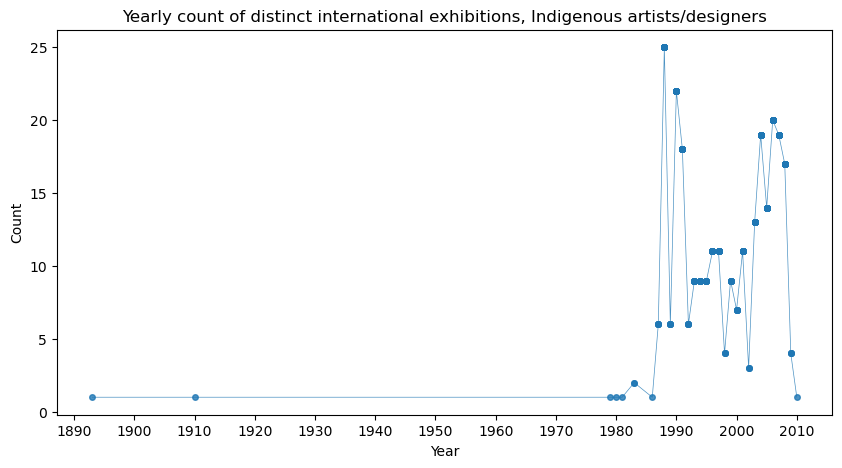

In [298]:
# # takes 2 mins to run
# relevant_events = pd.DataFrame()

# for idx,row in persons[persons.is_indigenous == True].iterrows():
#     try: 
#         this_person = pd.json_normalize(json.loads(row['related_events']))
#         for event_id in this_person['object.ori_dbid.$oid'].values:
#             this_event = events[events['ori_dbid'].str.contains(event_id, na=False)]['coverage_ranges'].values[0]
#             this_event_df = pd.json_normalize(json.loads(this_event))
#             this_event_df['name'] = row['display_name']
#             this_event_df['event_id'] = event_id
#             relevant_events = relevant_events.append(this_event_df)
#     except: pass

# relevant_events.to_csv('data/local/DAAO_indigeneous_analysis_relevant_events.csv', index=False)

relevant_events = pd.read_csv('data/local/DAAO_indigeneous_analysis_relevant_events.csv')

# indigeneous artists/designers with the most international events
international_events = relevant_events[(relevant_events['place.address.country'] != 'Australia') &\
                                       (relevant_events['place.address.country'].notnull())]

print('Indigeneous artists/designers with the most international exhibitions:')
display(international_events['name'].value_counts().head(5))

years_raw = international_events[international_events['date_range.date_start.year'].notnull()]['date_range.date_start.year']\
        .astype(int).to_list()

years = international_events[international_events['date_range.date_start.year'].notnull()]\
        .drop_duplicates(subset=['event_id'])['date_range.date_start.year'].astype(int).to_list()

# plot a line plot of yearly count of international events over time
plt.figure(figsize=(10,5))
plt.plot(sorted(years), [years.count(y) for y in sorted(years)], marker='o', linewidth=0.5, markersize=4, alpha=0.8)

# set x-axis
plt.xticks(np.arange(1890, 2011, 10.0))

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Yearly count of distinct international exhibitions, Indigenous artists/designers')
plt.show()

Non-indigeneous artists/designers with the most international events:


"Gwyn Hanssen Pigott"    66
"Mike Parr"              35
"James Fraser Scott"     33
"Stelarc"                27
"Luca Gansser"           27
Name: name, dtype: int64

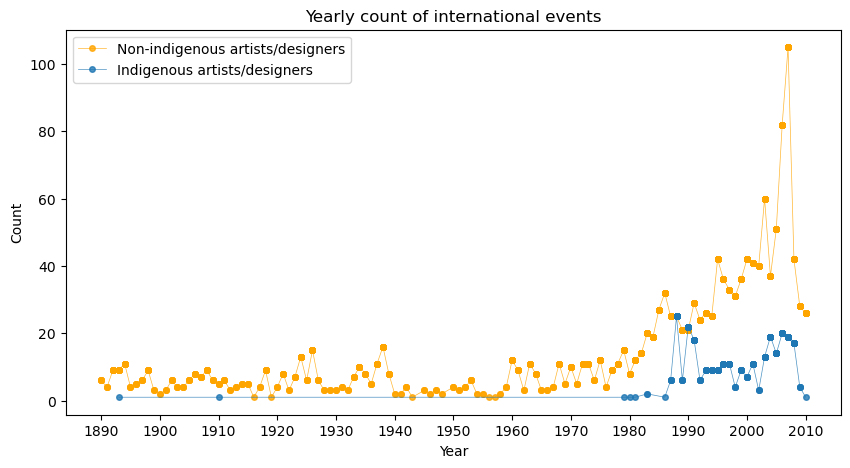

In [300]:
# # takes 12 mins to run
# relevant_events2 = pd.DataFrame()

# for idx,row in persons[persons.is_indigenous == False].iterrows():
#     try: 
#         this_person = pd.json_normalize(json.loads(row['related_events']))
#         for event_id in this_person['object.ori_dbid.$oid'].values:
#             this_event = events[events['ori_dbid'].str.contains(event_id, na=False)]['coverage_ranges'].values[0]
#             this_event_df = pd.json_normalize(json.loads(this_event))
#             this_event_df['name'] = row['display_name']
#             this_event_df['event_id'] = event_id
#             relevant_events2 = relevant_events2.append(this_event_df)
#     except: pass

# relevant_events2.to_csv('data/local/DAAO_indigeneous_analysis_relevant_events2.csv', index=False)

relevant_events2 = pd.read_csv('data/local/DAAO_indigeneous_analysis_relevant_events2.csv')


# indigeneous artists/designers with the most international events
international_events2 = relevant_events2[(relevant_events2['place.address.country'] != 'Australia') &\
                                       (relevant_events2['place.address.country'].notnull())]

print('Non-indigeneous artists/designers with the most international events:')
display(international_events2['name'].value_counts().head(5))

years2_raw = international_events2[international_events2['date_range.date_start.year'].notnull()]['date_range.date_start.year']\
        .astype(int).to_list()

# remove years before 1890 and after 2010
years2_raw = [y for y in years2_raw if y >= 1890 and y <= 2010]

years2 = international_events2[international_events2['date_range.date_start.year'].notnull()]\
        .drop_duplicates(subset=['event_id'])['date_range.date_start.year'].astype(int).to_list()

# remove years before 1890 and after 2010
years2 = [y for y in years2 if y >= 1890 and y <= 2010]

# plot a line plot of yearly count of international events over time
plt.figure(figsize=(10,5))
plt.plot(sorted(years2), [years2.count(y) for y in sorted(years2)], label='Non-indigenous artists/designers',
         marker='o', linewidth=0.5, markersize=4, color='orange', alpha=0.8)
plt.plot(sorted(years), [years.count(y) for y in sorted(years)], label='Indigenous artists/designers',
         marker='o', linewidth=0.5, markersize=4, alpha=0.8)

plt.legend()
# set x-axis
plt.xticks(np.arange(1890, 2011, 10.0))

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Yearly count of international events')
plt.show()

**1893 in context**

This year marks the first recorded entry of an indigeneous artist/designer participating in an international exhibition. According to the DAAO,

> *Mickey of Ulladulla was an Aboriginal artist active in the ninetenth century on the south coast of NSW. Five of his paintings were included posthumously in the catalogue of exhibits in the NSW Courts at the Chicago Exposition in 1893.*

</br>

**1910 in context**

Another early entry occurred in 1910. According to the DAAO,

> *Celebrated shellworker, Emma Timbery of La Perouse, NSW, exhibited her shellworks in England in 1910.*

</br>

**1988 in context**

The highest number of recorded exhibitions with indigenous artists/designers occurred in 1988. This is the only year where the number of international exhibitions with indigenous artists/designers (25) was equal to the number of international exhibitions with non-indigenous artists/designers (25).

- 16 out of these 25 exhibitions were held in the US. The rest were held in Tahiti (6), UK (2), and China (1).
- Gauguin Museum in Tahiti held the most number of exhibitions in 1988 (6).
- There are 21 distinct indigenous artists/designers:
    - Clifford Possum Tjapaltjarri exhibited three times (London, New York, and St Louis)
    - Colin Tjapanangka Dixon exhibited twice (Los Angeles and Tahiti)
    - Bessie Nakamarra Sims exhibited twice (Seattle and New York)
    - The rest exhibited once

</br>

**1990 in context**

This is the only year where the number of international exhibitions with indigenous artists/designers (22) exceeded the number of international exhibitions with non-indigenous artists/designers (21).

- 8 out of these 22 exhibitions were held in the US. The rest were held in the UK (7), France (5), Italy (3), Ireland (2), India (1), Vanuatu (1) and Spain (1).
- Musée Fabre in Montepellier, France held the most number of exhibitions in 1990 (4).
- There are 21 distinct indigenous artists/designers: 
    - Gloria Petyarre exhibited three times (London, Dublin, and India)
    - Robert Campbell exhibited three times (Manchester, Montpellier, and Boston)
    - Nyukana Baker exhibited twice (Edinburgh and New Mexico)
    - Emily Kame Kngwarreye exhibited twice (Dublin and Boston)
    - Trevor Nickolls exhibited twice (Venice)
    - The rest exhibited once

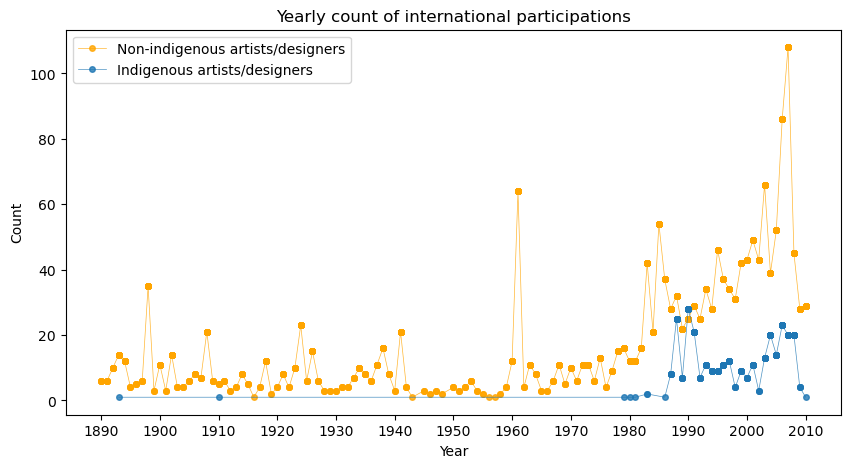

In [301]:
# plot a line plot of yearly count of international events over time
plt.figure(figsize=(10,5))
plt.plot(sorted(years2_raw), [years2_raw.count(y) for y in sorted(years2_raw)], label='Non-indigenous artists/designers',
         marker='o', linewidth=0.5, markersize=4, color='orange', alpha=0.8)
plt.plot(sorted(years_raw), [years_raw.count(y) for y in sorted(years_raw)], label='Indigenous artists/designers',
         marker='o', linewidth=0.5, markersize=4, alpha=0.8)

plt.legend()
# set x-axis
plt.xticks(np.arange(1890, 2011, 10.0))

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Yearly count of international participations')
plt.show()

**1898 in context**

There are 35 non-indegenous artists/designers associated with international exhibitions in 1898. 27 of these artists/designers performed at the same exhibition in the UK. The exhibition was held at the Grafton Gallery in London. The exhibition was called *Exhibition of Australian Art*.

</br>

**1961 in context**

This peak consists of 64 non-indegenous artists/designers associated with international exhibitions in 1961. 55 of these artists/designers performed at the same exhibition in the UK. The exhibition was held at the Whitechapel Gallery in London between June and July. The exhibition was called *Recent Australian Painting*.

</br>

**2007 in context**

The highest peak occurred in 2007 which consisted of 108 non-indegenous artists/designers associated with international exhibitions. Most exhibitions are held across Europe. The exhibition network in 2007 is a lot more sparse than the aforementioned years with only two exhibitions including two distinct artists/designers from the DAAO. The rest of the exhibitions only include one artist/designer from the DAAO.

### Key takeaways:

- US (28%), UK (13%) and France (12%) are the top 3 countries with the highest number of exhibitions for indigenous artists/designers.
- Similarly, UK (36%), US (13%) and France (10%) are also the top 3 countries with the highest number of exhibitions for non-indigenous artists/designers.
- Considering raw counts, Greece is the only country that has more exhibitions for indigenous artists/designers than non-indigenous artists/designers.

In terms of proportion ratios, 
- Indigenous artists/designers are roughly **three times more likely** to have exhibitions in Austria and Netherlands
- Indigenous artists/designers are roughly **two times more likely** to have exhibitions in US and Germany
- France, Canada and China approximartely hold a one-to-one ratio of exhibitions for indigenous and non-indigenous artists/designers.
- While Japan, New Zealand and UK are more likely to have exhibitions for non-indigenous artists/designers.
- UK is almost **three times more likely** to have exhibitions for non-indigenous artists/designers than indigenous artists/designers.

Below we show countries with at least 5 exhibitions for indigenous artists/designers. This list is sorted by the ratio of exhibitions for indigenous artists/designers to non-indigenous artists/designers.

In [302]:
indigenous_stats = pd.merge(international_events['place.address.country'].value_counts().reset_index(),
                    international_events['place.address.country'].value_counts(normalize=True).reset_index(), on='index').\
                    rename(columns={'index':'country', 'place.address.country_x':'count', 'place.address.country_y':'percentage'})

non_indigenous_stats = pd.merge(international_events2['place.address.country'].value_counts().reset_index(),
                    international_events2['place.address.country'].value_counts(normalize=True).reset_index(), on='index').\
                    rename(columns={'index':'country', 'place.address.country_x':'count', 'place.address.country_y':'percentage'})

all_stats = pd.merge(indigenous_stats,non_indigenous_stats, # how='outer',
                     on='country', suffixes=('_indigenous', '_non_indigenous'))

all_stats['ratio'] = all_stats['percentage_indigenous'] / all_stats['percentage_non_indigenous']
all_stats = all_stats[all_stats['count_indigenous'] > 5]
all_stats.sort_values('ratio', ascending=False)

,country,count_indigenous,percentage_indigenous,count_non_indigenous,percentage_non_indigenous,ratio
11,Greece,6,0.018349,4,0.001530,11.990826
10,Austria,7,0.021407,18,0.006886,3.108733
7,Netherlands,10,0.030581,29,0.011094,2.756512
0,United States,94,0.287462,329,0.125861,2.283967
3,Germany,23,0.070336,104,0.039786,1.767878
4,Italy,16,0.048930,80,0.030604,1.598777
2,France,40,0.122324,258,0.098699,1.239362
6,Canada,11,0.033639,84,0.032135,1.046818
8,China,10,0.030581,89,0.034047,0.898189
9,Japan,9,0.027523,98,0.037490,0.734132
